To use a batched A2C we have to adapt both the step method and how we store information for the update.
In particular:
1. Instead of using observations of the environment with everything attached, elaborate the information and extract only the useful variables, so that they can be stacked in numpy arrays when possbile.
2. step method works with observation, but should work with a batch of states and available actions; Probably it will be infeasible to vectorize the selection of the parameters of the actions, because the output and the procedure varies from action to action.
3. The part in which we compute the loss is okay, because we use only the critic to make predictions, so the only problem is to store the information in batches.

NOTE: remember to add all networks to the optimizer initialization

In [1]:
from Utils.train_batched_A2C import *
from AC_modules.BatchedA2C import MoveToBeaconSpatialA2C
import AC_modules.Networks as net
import torch

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def train_batched_A2C(agent, game_params, lr, n_train_processes, max_train_steps, 
                      unroll_length, max_episode_steps, test_interval=100):
    
    test_env = init_game(game_params, max_episode_steps)
    envs = ParallelEnv(n_train_processes, game_params, max_episode_steps)

    optimizer = torch.optim.Adam(agent.AC.parameters(), lr=lr)

    score = []
    critic_losses = [] 
    actor_losses = []
    entropies = []
    
    step_idx = 0
    while step_idx < max_train_steps:
        s_lst, a_lst, r_lst, done_lst, bootstrap_lst, s_trg_lst = list(), list(), list(), list(), list(), list()
        log_probs = []
        distributions = []
        s, a_mask = envs.reset()
        for _ in range(unroll_length):

            a, log_prob, probs = agent.step(s, a_mask)
            a_lst.append(a)
            log_probs.append(log_prob)
            distributions.append(probs)

            s_prime, r, done, bootstrap, s_trg, a_mask = envs.step(a)
            s_lst.append(s)
            r_lst.append(r)
            done_lst.append(done)
            bootstrap_lst.append(bootstrap)
            s_trg_lst.append(s_trg)

            s = s_prime
            step_idx += 1 #n_train_processes

        s_lst = np.array(s_lst).transpose(1,0,2,3,4)
        r_lst = np.array(r_lst).transpose(1,0)
        done_lst = np.array(done_lst).transpose(1,0)
        bootstrap_lst = np.array(bootstrap_lst).transpose(1,0)
        s_trg_lst = np.array(s_trg_lst).transpose(1,0,2,3,4)
        
        ### Update time ###
        #print("len(r_lst): ", r_lst.shape)
        #print("len(s_lst): ", s_lst.shape)
        #print("len(done_lst): ", done_lst.shape)
        #print("len(s_trg_lst): ", s_trg_lst.shape)
        critic_loss, actor_loss, entropy = agent.compute_ac_loss(r_lst, log_probs, distributions, 
                                                                 s_lst, done_lst, bootstrap_lst, s_trg_lst)

        
        loss = (critic_loss + actor_loss).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #print("critic_loss: ", critic_loss)
        #print("actor_loss: ", actor_loss)
        #print("entropy: ", entropy)
        critic_losses.append(critic_loss.item())
        actor_losses.append(actor_loss.item())
        entropies.append(entropy.item())
        
        ### Test time ###
        if step_idx % test_interval == 0:
            avg_score = test(step_idx, agent, test_env)
            score.append(avg_score)
    envs.close()
    
    losses = dict(critic_losses=critic_losses, actor_losses=actor_losses, entropies=entropies)
    return score, losses, agent

In [3]:
def test(step_idx, agent, test_env):
    score = 0.0
    done = False
    num_test = 2
    for _ in range(num_test):
        
        obs = test_env.reset()
        s = get_ohe_state(obs)[np.newaxis, ...] # add batch dim
        available_actions = obs[0].observation.available_actions
        a_mask = get_action_mask(available_actions)[np.newaxis, ...] # add batch dim
        
        rewards = []
        while not done:
            a, log_prob, probs = agent.step(s, a_mask)
            obs = test_env.step(a)
            s_prime = get_ohe_state(obs)[np.newaxis, ...] # add batch dim
            reward = obs[0].reward
            done = obs[0].last()
            available_actions = obs[0].observation.available_actions
            a_mask = get_action_mask(available_actions)[np.newaxis, ...] # add batch dim
            
            s = s_prime
            score += reward
            rewards.append(reward)
        done = False

    print(f"Step # : {step_idx}, avg score : {score/num_test:.1f}")
    return score/num_test

In [4]:
RESOLUTION = 16
MAX_STEPS = 256
game_params = dict(feature_screen=RESOLUTION, feature_minimap=RESOLUTION, action_space="FEATURES") 

In [5]:
env = init_game(game_params, max_steps=MAX_STEPS)

In [6]:
# Define the two models used in the architecture
model_number = 1
model_names = {0:"FullyConvNet_v0", 1:"FullyConvNet_v1", 2:"ControlNet", 3:"GatedRelationalNet"}

if model_number == 0:
    print(model_names[model_number]+" selected.")
    spatial_model = net.FullyConvSpatial
    nonspatial_model = net.FullyConvNonSpatial
    n_channels = 32
    n_features = 256
    spatial_dict = {"in_channels":3}
    nonspatial_dict = {}
    
if model_number == 1:
    print(model_names[model_number]+" selected.")
    spatial_model = net.FullyConvSpatial_v1
    nonspatial_model = net.FullyConvNonSpatial_v1
    n_channels = 32
    n_features = 256
    spatial_dict = {"in_channels":3}
    nonspatial_dict = {}
    
elif model_number == 2:
    print(model_names[model_number]+" selected.")
    spatial_model = net.SpatialFeatures
    nonspatial_model = net.NonSpatialFeatures
    n_channels = 32
    n_features = 32
    spatial_dict = dict(n_layers=2, linear_size=RESOLUTION, in_channels=3, n_channels=n_features)
    nonspatial_dict = dict(linear_size=RESOLUTION, n_channels=n_features, pixel_hidden_dim=128, pixel_n_residuals=2, 
                 feature_hidden_dim=256, feature_n_residuals=2)
elif model_number == 3:
    print(model_names[model_number]+" selected.")
    patial_model = net.SpatialFeatures
    nonspatial_model = net.GatedRelationalNet
    n_channels = 32
    n_features = 32
    spatial_dict = dict(n_layers=2, linear_size=RESOLUTION, in_channels=3, n_channels=n_features)

    nonspatial_dict = dict(n_kernels=n_features, n_features=n_features, n_heads=1, n_attn_modules=2, 
                     feature_hidden_dim=16, feature_n_residuals=1)

else:
    print("Model number not available. Choose 0, 1, 2 or 3.")

FullyConvNet selected.


In [19]:
HPs = dict(action_space=3, gamma=0.99, n_steps=5, spatial_model=spatial_model, nonspatial_model=nonspatial_model,
           n_features=n_features, n_channels=n_channels, spatial_dict=spatial_dict, nonspatial_dict=nonspatial_dict)

if torch.cuda.is_available():
    HPs['device'] = 'cuda'
else:
    HPs['device'] = 'cpu'
    
print("Using device "+HPs['device'])

lr = 1e-3
agent = MoveToBeaconSpatialA2C(env=env, **HPs)

Using device cuda


In [29]:
unroll_length = 240

train_dict = dict(n_train_processes = 11,
                  max_train_steps = unroll_length*5000,
                  unroll_length = unroll_length,
                  max_episode_steps = MAX_STEPS,
                  test_interval = unroll_length*10 #100
                  )

Learning rates to try:
- 1e-3
- 3e-4 (this was with learning rate schedule)

In [21]:
%%time
results = train_batched_A2C(agent, game_params, lr, **train_dict)

Step # : 2400, avg score : 0.0
Step # : 4800, avg score : 2.0
Step # : 7200, avg score : 1.0
Step # : 9600, avg score : 2.5
Step # : 12000, avg score : 2.0
Step # : 14400, avg score : 1.0
Step # : 16800, avg score : 2.0
Step # : 19200, avg score : 1.0
Step # : 21600, avg score : 0.5
Step # : 24000, avg score : 1.0
Step # : 26400, avg score : 2.0
Step # : 28800, avg score : 2.0
Step # : 31200, avg score : 0.0
Step # : 33600, avg score : 3.0
Step # : 36000, avg score : 2.0
Step # : 38400, avg score : 1.0
Step # : 40800, avg score : 2.0
Step # : 43200, avg score : 1.5
Step # : 45600, avg score : 0.5
Step # : 48000, avg score : 1.0
Step # : 50400, avg score : 2.5
Step # : 52800, avg score : 1.0
Step # : 55200, avg score : 0.5
Step # : 57600, avg score : 2.5
Step # : 60000, avg score : 3.5
Step # : 62400, avg score : 2.5
Step # : 64800, avg score : 0.5
Step # : 67200, avg score : 1.0
Step # : 69600, avg score : 1.0
Step # : 72000, avg score : 1.5
Step # : 74400, avg score : 3.5
Step # : 768

In [38]:
%%time
results = train_batched_A2C(trained_agent, game_params, lr, **train_dict)

Step # : 2400, avg score : 2.0
Step # : 4800, avg score : 6.5
Step # : 7200, avg score : 5.0
Step # : 9600, avg score : 5.0
Step # : 12000, avg score : 2.0
Step # : 14400, avg score : 2.0
Step # : 16800, avg score : 5.5
Step # : 19200, avg score : 3.5
Step # : 21600, avg score : 4.5
Step # : 24000, avg score : 5.0
Step # : 26400, avg score : 5.0
Step # : 28800, avg score : 5.5
Step # : 31200, avg score : 4.0
Step # : 33600, avg score : 3.5
Step # : 36000, avg score : 4.5
Step # : 38400, avg score : 4.0
Step # : 40800, avg score : 3.5
Step # : 43200, avg score : 5.5
Step # : 45600, avg score : 4.5
Step # : 48000, avg score : 3.5
Step # : 50400, avg score : 5.0
Step # : 52800, avg score : 5.5
Step # : 55200, avg score : 5.5
Step # : 57600, avg score : 5.0
Step # : 60000, avg score : 6.0
Step # : 62400, avg score : 5.0
Step # : 64800, avg score : 5.0
Step # : 67200, avg score : 5.5
Step # : 69600, avg score : 4.0
Step # : 72000, avg score : 4.5
Step # : 74400, avg score : 8.0
Step # : 768

Step # : 600000, avg score : 0.0
Step # : 602400, avg score : 0.0
Step # : 604800, avg score : 0.0
Step # : 607200, avg score : 0.0
Step # : 609600, avg score : 0.0
Step # : 612000, avg score : 0.0
Step # : 614400, avg score : 0.0
Step # : 616800, avg score : 0.0
Step # : 619200, avg score : 0.0
Step # : 621600, avg score : 0.0
Step # : 624000, avg score : 0.0
Step # : 626400, avg score : 0.0
Step # : 628800, avg score : 0.0
Step # : 631200, avg score : 0.0
Step # : 633600, avg score : 0.0
Step # : 636000, avg score : 0.0
Step # : 638400, avg score : 0.0
Step # : 640800, avg score : 0.0
Step # : 643200, avg score : 0.0
Step # : 645600, avg score : 0.0
Step # : 648000, avg score : 0.0
Step # : 650400, avg score : 0.0
Step # : 652800, avg score : 0.0
Step # : 655200, avg score : 0.0
Step # : 657600, avg score : 0.0
Step # : 660000, avg score : 0.0
Step # : 662400, avg score : 0.0
Step # : 664800, avg score : 0.0
Step # : 667200, avg score : 0.0
Step # : 669600, avg score : 0.0
Step # : 6

Step # : 1190400, avg score : 0.0
Step # : 1192800, avg score : 0.0
Step # : 1195200, avg score : 0.0
Step # : 1197600, avg score : 0.0
Step # : 1200000, avg score : 0.0
CPU times: user 4h 26min 9s, sys: 7min 43s, total: 4h 33min 52s
Wall time: 6h 8min 3s


### Models tried:

**FullyConv_v0**
- Spatial network: 
    - conv 5x5, padding 2, 16 kernels 
    - ReLU
    - conv 3x3, padding 1, 32 kernels
    - ReLU
- Non-Spatial network: flatten on pixel dimensions (16x16 -> 256) + linear layer (256 -> 1) with ReLU

We obtain a 32-dimensional vector, used to compute the policy, value and categorical (non-spatial) parameters.
- Policy net: 32 -> 256 -> ReLU -> n_actions (3)
- Value net: 32 -> 256 -> ReLU -> 1
- Categorical net: 32 -> 256 -> ReLU -> n_values (usually 2, for boolean flags)

To compute the spatial parameters:
- Conv2d 1x1 kernel from 32 to 1 channels (obtain 1 channel image and sample the pixel after softmax)

Learning rates tried:
- $10^{-4}$ for 1M+ steps -> nothing
- $5\cdot10^{-5}$ for 2M+ steps -> nothing

n-steps used: 20 ( not 100% sure they were 20 in the first trial, maybe they were 5)

**FullyConv**
- Spatial network: 
    - conv 5x5, padding 2, 16 kernels 
    - ReLU
    - conv 3x3, padding 1, 32 kernels
    - ReLU
- Non-Spatial network: flatten on pixel + channel dimensions (32x16x16 -> 8192) + linear layer (8192 -> 256) with ReLU

We obtain a 256-dimensional vector, used to compute the policy, value and categorical (non-spatial) parameters.
- Policy net: 256-> n_actions (3)
- Value net: 256 -> 1
- Categorical net: 256 -> 256 -> ReLU -> n_values (usually 2, for boolean flags)

To compute the spatial parameters:
- Conv2d 1x1 kernel from 32 to 1 channels (obtain 1 channel image and sample the pixel after softmax)

Learning rates tried:
- $10^{-4}$ for 1M+ steps -> nothing
- $5\cdot10^{-5}$ for 1.2M steps -> slight improvement (from 1.5 to 3 something) - training part 2

n-steps used: 20 first trial w/ lr 1e-4, now 5 steps

**OheNet**
- Spatial network: 
    - 1 conv layer (3x3, padding 1, 24 kernels), 
    - 1 residual conv layer (3x3 padding 1 + skip connection, 24 -> 24 channels)
- Non-Spatial network:
    - 2 residual layers on pixel dim (256 -> LayerNorm -> 128 -> ReLU -> 256 + skip connection)
    - Featurewise maxpool (24,256) -> (24)
    - 2 residual layers on feature dim (32 -> LayerNorm -> 256 -> ReLU -> 32 + skip connection)
    
Same networks for policy, value and categorical parameters. Slightly different for spatial parameters (3x3 conv w/ 1 padding instead of 1x1 conv w/ 0 padding)

Learning rates tried:
- $5\cdot 10^{-5}$ for 1.2M steps -> reward peak at 15 (800k steps) and then collapse to random baseline

Episodes per test: 2

test every 10:  8min 58s = 538 s (24k steps) <br>
test every 20:  8min 39s = 519 s (24k steps) <br>

Episodes per test: 10

test every 10: 11min 3s = 663 s (24k steps) <br>
test every 20: 9min 44s = 584 s (24k steps) <br>
test every 10: 9min 44s = 584 s (24k steps) - FullyConv <br>


Percentage increase in number episodes (count n parallel processes as 1 for semplicity)
+ 2/10* 100*K= 20*K% = 7.6%
+ 1/10* 100*K = 10*K% = 3.8%
+ 1* 100*K = 100*K% = 38%
+ 2* 100*K = 200*K% = 76%

$t = (\frac{20K}{100}+1)t_0$

$t_0$ identical for everyone, K idem -> 2 unknowns and 4 equations

$t_1+t_2 = (\frac{30K}{100}+2)t_0$ -> $t_1+t_2 = (\frac{30K}{100}+2)(t_1 - t_2)\frac{100}{10K}$

$t_1-t_2 = (\frac{10K}{100})t_0$ -> $t_0 = (t_1 - t_2)\frac{100}{10K}$

K = 0.38

In [39]:
score, losses, trained_agent = results

In [40]:
from Utils import utils
save = True
keywords = ['batched-A2C', "fully-conv",'lr-1e-3','5-steps', "1.2M-env-steps","240-steps",'COYJ-pt2'] 

if save:
    save_dir = 'Results/MoveToBeacon/'
    ID = utils.save_session(save_dir, keywords, game_params, HPs, score, losses)
    torch.save(trained_agent, save_dir+"agent_"+ID)
else:
    print("Nothing saved")
    pass

Save at Results/MoveToBeacon/S_batched-A2C_fully-conv_lr-1e-3_5-steps_1.2M-env-steps_240-steps_COYJ-pt2_WUCM


/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type SpatialActorCritic. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type FullyConvSpatial. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__nam

In [33]:
import matplotlib.pyplot as plt
import numpy as np

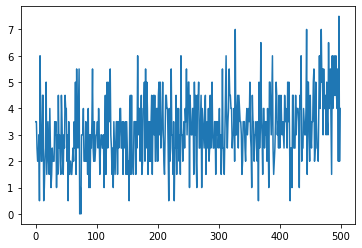

In [34]:
plt.plot(np.arange(len(score)), score)

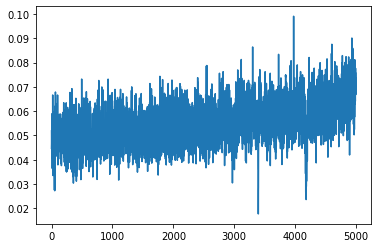

In [35]:
n_epochs = np.arange(len(losses['critic_losses']))
plt.plot(n_epochs, losses['critic_losses'])

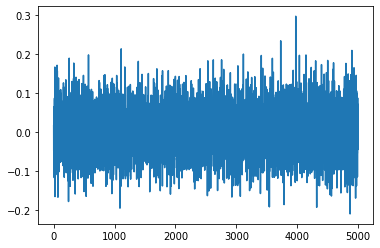

In [36]:
plt.plot(n_epochs, losses['actor_losses'])

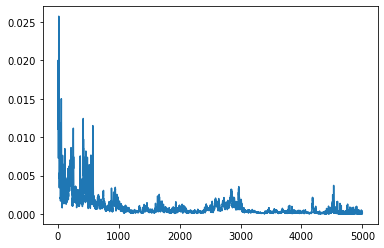

In [37]:
plt.plot(n_epochs, -np.array(losses['entropies']))

# Line by line

In [ ]:
RESOLUTION = 16
MAX_STEPS = 256
game_params = dict(feature_screen=RESOLUTION, feature_minimap=RESOLUTION, action_space="FEATURES") 

In [ ]:
env = init_game(game_params, max_steps=MAX_STEPS)

In [ ]:
HPs = dict(action_space=3, n_layers=2, in_channels=3, n_channels=12, linear_size=RESOLUTION,
           gamma=0.99, n_steps = 20, pixel_n_residuals=2, feature_n_residuals=2)

if torch.cuda.is_available():
    HPs['device'] = 'cuda'
else:
    HPs['device'] = 'cpu'
    
print("Using device "+HPs['device'])

lr = 1e-4
agent = MoveToBeaconSpatialA2C(env=env, **HPs)

In [ ]:
unroll_length = 240

train_dict = dict(n_train_processes = 11,
                  max_train_steps = unroll_length*100,
                  unroll_length = unroll_length,
                  max_episode_steps = MAX_STEPS,
                  test_interval = unroll_length*10 #100
                  )

In [7]:
envs = ParallelEnv(n_train_processes, game_params, max_steps)

reset done
info sent
reset done
info sent


In [8]:
optimizer = torch.optim.Adam(agent.AC.parameters(), lr=lr)

In [9]:
s, a_mask = envs.reset()
print("s.shape: ", s.shape)
print("a_mask.shape: ", a_mask.shape)
print("a_mask: ", a_mask)

s.shape:  (2, 3, 16, 16)
a_mask.shape:  (2, 3)
a_mask:  [[False False  True]
 [False False  True]]


## AC step

To make a batched step we already have the state in the correct shape, but we need to:
1. change get_action_mask of the AC so to work with a list of arrays - DONE
2. sample all parameters every time, so that we don't need to loop between the parameter networks to get the right ones and we can vectorize it
3. select only the parameters that we neeed

Each action has 0, 1 or 2 parameters associated. We should sample a batch of arguments for each parameter of each argument and then access only the correct ones. We need a bit of structure to do that.

(batch_dim, [[params0],[params1],[params2]])
and same thing for the log_prob

Unfortunately we get something like ([[],[(batch_dim, args)],[(batch_dim, arg1),(batch_dim, arg2)]])

In [10]:
action, log_prob, probs = agent.step(s, a_mask)


action mask:  tensor([[False, False,  True],
        [False, False,  True]], device='cuda:0')
logits shape:  torch.Size([2, 3])
logits:  tensor([[-1.6008, -0.7392, -1.1371],
        [-1.7987, -0.6966, -1.0900]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
mask shape:  torch.Size([2, 3])
mask:  tensor([[False, False,  True],
        [False, False,  True]], device='cuda:0')
logits (after mask):  tensor([[-1.6008, -0.7392,    -inf],
        [-1.7987, -0.6966,    -inf]], device='cuda:0',
       grad_fn=<IndexPutBackward>)
log_probs:  tensor([[-1.2141, -0.3524,    -inf],
        [-1.3889, -0.2868,    -inf]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
spatial_features.shape:  torch.Size([2, 12, 16, 16])
spatial_features (cuda):  True
nonspatial_features.shape:  torch.Size([2, 12])
nonspatial_features (cuda):  True
probs:  tensor([[0.2970, 0.7030, 0.0000],
        [0.2493, 0.7507, 0.0000]], device='cuda:0', grad_fn=<ExpBackward>)
log_prob:  tensor([-0.3524, -0.2868], dev

In [11]:
s_prime, r, done, bootstrap, s_trg, a_mask = envs.step(action)


In [13]:
print("s_prime.shape; ", s_prime.shape)
print("r.shape: ", r.shape)
print("done.shape: ", done.shape)
print("bootstrap.shape: ", bootstrap.shape)
print("s_trg.shape: ", s_trg.shape)
print("a_mask.shape: ", a_mask.shape)

s_prime.shape;  (2, 3, 16, 16)
r.shape:  (2,)
done.shape:  (2,)
bootstrap.shape:  (2,)
s_trg.shape:  (2, 3, 16, 16)
a_mask.shape:  (2, 3)


In [16]:
#print("s_prime: ", s_prime)
print("r: ", r)
print("done: ", done)
print("bootstrap: ", bootstrap)
#print("s_trg: ", s_trg)
print("a_mask: ", a_mask)

r:  [0 0]
done:  [False False]
bootstrap:  [False False]
a_mask:  [[False False False]
 [False False False]]


In [15]:
action, log_prob, probs = agent.step(s_prime, a_mask)


action mask:  tensor([[False, False, False],
        [False, False, False]], device='cuda:0')
logits shape:  torch.Size([2, 3])
logits:  tensor([[-1.6421, -0.7365, -1.1158],
        [-1.7094, -0.7659, -1.0381]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
mask shape:  torch.Size([2, 3])
mask:  tensor([[False, False, False],
        [False, False, False]], device='cuda:0')
logits (after mask):  tensor([[-1.6421, -0.7365, -1.1158],
        [-1.7094, -0.7659, -1.0381]], device='cuda:0',
       grad_fn=<IndexPutBackward>)
log_probs:  tensor([[-1.6421, -0.7365, -1.1158],
        [-1.7094, -0.7659, -1.0381]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
spatial_features.shape:  torch.Size([2, 12, 16, 16])
spatial_features (cuda):  True
nonspatial_features.shape:  torch.Size([2, 12])
nonspatial_features (cuda):  True
probs:  tensor([[0.1936, 0.4788, 0.3277],
        [0.1810, 0.4649, 0.3541]], device='cuda:0', grad_fn=<ExpBackward>)
log_prob:  tensor([-0.7365, -1.0381], dev

In [17]:
s_prime, r, done, bootstrap, s_trg, a_mask = envs.step(action)

In [19]:
envs.close()

In [15]:
import torch
import torch.nn.functional as F

In [26]:
logits = torch.rand((2,3), requires_grad=True)
mask = torch.tensor([[False, False, True], [False, False, True]])
x = F.log_softmax(logits.masked_fill((mask).bool(), float('-inf')), dim=-1) 

In [28]:
x.sum().backward()